<a href="https://colab.research.google.com/github/Frixon21/CPSC-483-Introduction-to-Machine-Learning/blob/main/Ocupancy%20Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import time
from torch import nn

print(torch.__version__)

2.6.0+cpu


In [2]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv'
data = pd.read_csv(data_url)
data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [3]:
# Check for missing values
data.isnull().sum()
# Convert 'Date' and 'Time' into datetime format
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
# Drop the original 'Date' and 'Time' columns
data = data.drop(['Date', 'Time'], axis=1)
data['DateTime'] = data['DateTime'].apply(lambda  var: time.mktime(var.timetuple()))
data = data.set_index('DateTime')
data = data.sort_index()
data.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
DateTime,,,,,,,,,,,,,,,,,
1.513940e+09,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1.513940e+09,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
1.513940e+09,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
1.513940e+09,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
1.513940e+09,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


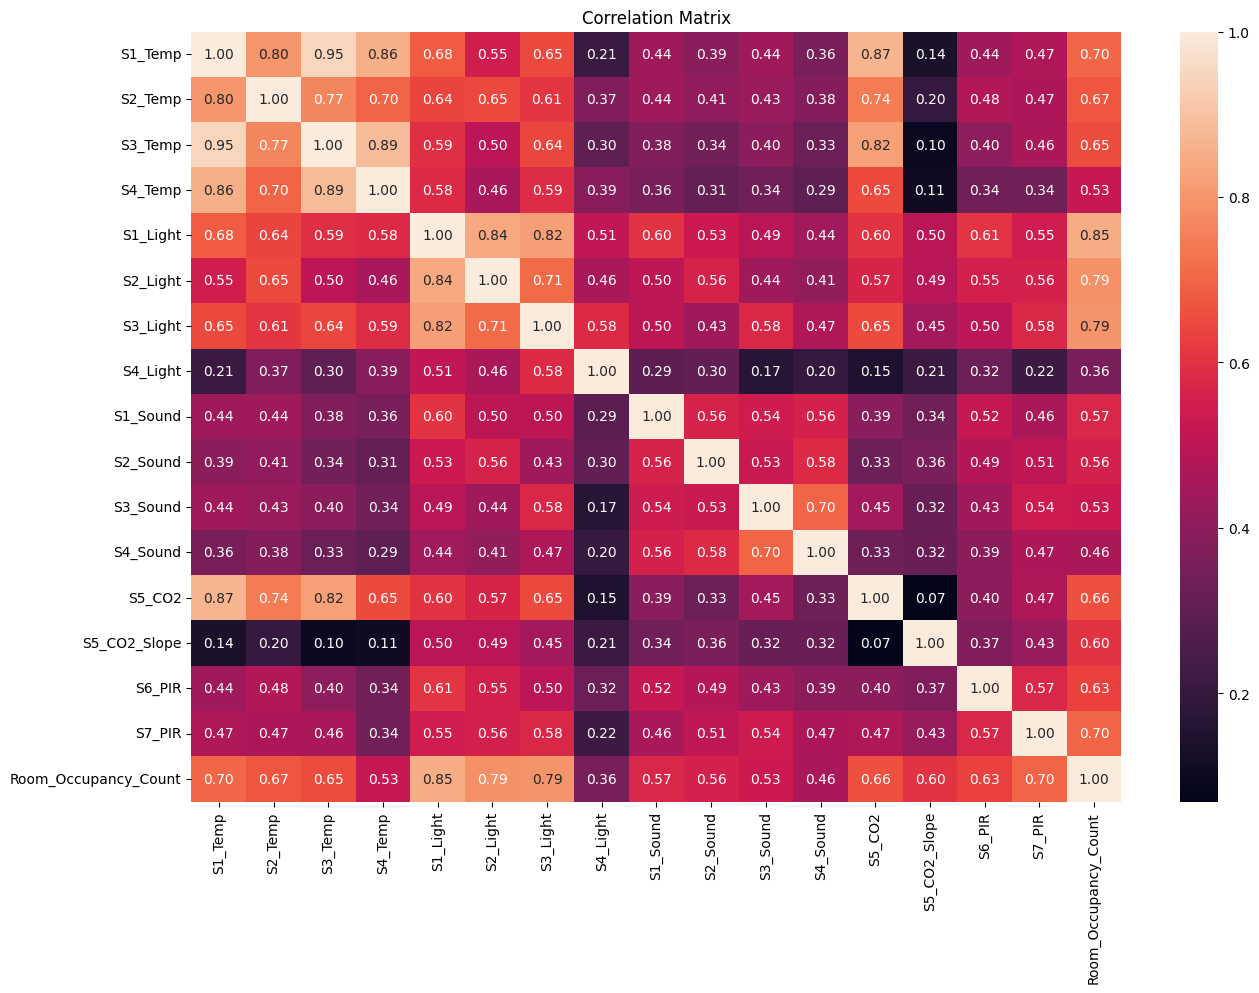

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Define the features and the target
X = data.drop('Room_Occupancy_Count', axis=1)
y = data['Room_Occupancy_Count']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the training set and test set
X_train.shape, X_test.shape

((8103, 16), (2026, 16))

In [6]:
from torch.utils.data import DataLoader, TensorDataset

# Convert the data to PyTorch tensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using cpu device


In [7]:
!pip install optuna
import optuna
from optuna.pruners import MedianPruner



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.4/602.4 kB 36.2 MB/s eta 0:00:00


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-6, 5e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    # Create data loaders with the suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the model
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 4)  # 4 outpouts 0,1,2,3
    ).to(device)


    # Define the loss function and the optimizer with the suggested learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    n_epochs = 20
    for epoch in range(n_epochs):
        for i, (inputs, targets) in enumerate(train_loader):
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)

    _, predictions = torch.max(outputs, 1)

    # Compute the validation accuracy
    val_acc = accuracy_score(y_test_tensor.cpu(), predictions.cpu())

    return -float(val_acc)  # Return the negative accuracy


def stop_if_good_enough(study, trial):
    if study.best_value < -0.995:
        study.stop()


def compute_accuracy(outputs, targets):
    # Apply the softmax function to convert the outputs into probabilities
    probabilities = torch.softmax(outputs, dim=1)

    # Get the class with the highest probability
    predictions = torch.argmax(probabilities, dim=1)

    # Compute the number of correct predictions
    correct_predictions = (predictions == targets).sum().item()

    # Compute the total number of predictions
    total_predictions = targets.size(0)

    # Compute and return the accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

# Create a study object and optimize the objective
study = optuna.create_study(pruner=MedianPruner(), direction='minimize')
study.optimize(objective, n_trials=100, callbacks=[stop_if_good_enough])

# Print the best hyperparameters
best_hyperparameters = study.best_params
print(f'Best Hyperparameters: {best_hyperparameters}')

[I 2025-03-26 04:35:56,247] A new study created in memory with name: no-name-1a017168-eb88-4f6e-bb52-a0b2a15314d9
[W 2025-03-26 04:38:28,377] Trial 0 failed with parameters: {'lr': 1.5459764327738903e-06, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-8-e61f9a91ad66>", line 32, in objective
    outputs = model(inputs)
              ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/l

KeyboardInterrupt: 

In [11]:
from torch.utils.tensorboard import SummaryWriter

# Best hyperparameters
best_hyperparameters = {'lr': 0.0004110051129893402, 'batch_size': 16} #Comment this if runing tuning
# {'lr': 0.0008208617392926794, 'batch_size': 16} #Option 2
# {'lr': 0.0015275703676401928, 'batch_size': 16} = -0.9906


# Create data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_hyperparameters['batch_size'], shuffle=False)

# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 4)
).to(device)

# Define the loss function and the optimizer with the best learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_hyperparameters['lr'])

train_losses = []
writer = SummaryWriter()

# Train the model
n_epochs = 50
for epoch in range(n_epochs):
    epoch_losses = []
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Remove the extra dimension
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        # Compute and log accuracy
        accuracy = compute_accuracy(outputs, targets)
        writer.add_scalar('Accuracy/train', accuracy, epoch)

    # Log the loss to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)

    # Log the magnitude of the gradients
    for name, param in model.named_parameters():
        writer.add_histogram(f'{name}.grad', param.grad.abs().mean().item(), epoch)

    epoch_loss = np.mean(epoch_losses)  # Compute the mean loss for this epoch
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')

writer.close()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
outputs = outputs.squeeze()
predictions = torch.argmax(outputs, dim=1)

# Compute the performance metrics
accuracy = accuracy_score(y_test_tensor.cpu(), predictions.cpu())
precision = precision_score(y_test_tensor.cpu(), predictions.cpu(), average='micro')
recall = recall_score(y_test_tensor.cpu(), predictions.cpu(), average='micro')
f1 = f1_score(y_test_tensor.cpu(), predictions.cpu(), average='micro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Epoch 1/50, Loss: 0.016108835116028786
Epoch 2/50, Loss: 0.6419951319694519
Epoch 3/50, Loss: 0.011025500483810902
Epoch 4/50, Loss: 0.0042580473236739635
Epoch 5/50, Loss: 0.00703820725902915
Epoch 6/50, Loss: 0.019486455246806145
Epoch 7/50, Loss: 0.000675853923894465
Epoch 8/50, Loss: 0.031337838619947433
Epoch 9/50, Loss: 0.22854535281658173
Epoch 10/50, Loss: 0.011438265442848206
Epoch 11/50, Loss: 0.006188124883919954
Epoch 12/50, Loss: 0.001382496440783143
Epoch 13/50, Loss: 0.0010706138564273715
Epoch 14/50, Loss: 0.004761303309351206
Epoch 15/50, Loss: 0.006914231460541487
Epoch 16/50, Loss: 0.0003275834023952484
Epoch 17/50, Loss: 0.0034418385475873947
Epoch 18/50, Loss: 0.07183245569467545
Epoch 19/50, Loss: 1.0407859086990356
Epoch 20/50, Loss: 2.036631303781178e-05
Epoch 21/50, Loss: 0.002700612647458911
Epoch 22/50, Loss: 0.001305132289417088
Epoch 23/50, Loss: 0.008997766301035881
Epoch 24/50, Loss: 0.016836779192090034
Epoch 25/50, Loss: 0.09122102707624435
Epoch 26/50,

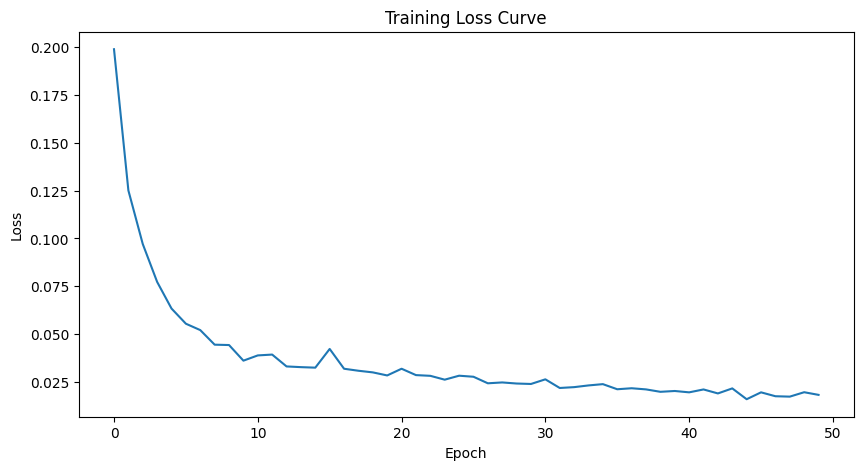

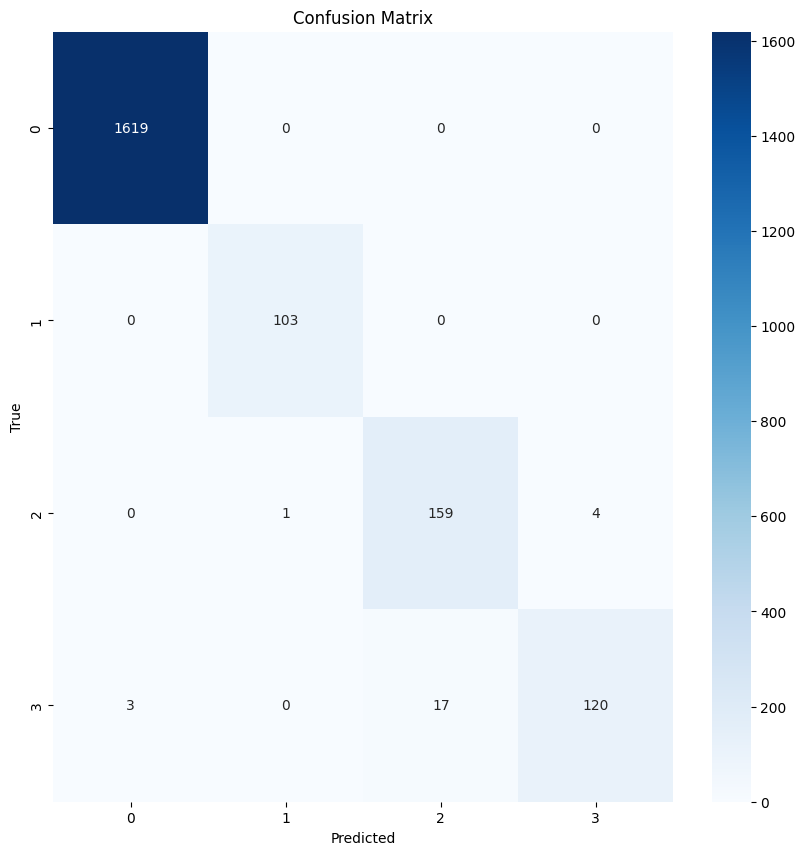

In [13]:
from sklearn.metrics import confusion_matrix
# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test_tensor.cpu(), predictions.cpu())

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()